In [111]:
import glob
import pandas as pd
all_files = glob.glob('data/traffic_data/*.csv')
traffic_data = pd.concat((pd.read_csv(f) for f in all_files))

In [82]:
traffic_data.head()

,human_count,timestamp
0,0,2020-10-16 17:07:19
1,0,2020-10-16 17:07:48
2,1,2020-10-16 17:08:18
3,0,2020-10-16 17:08:48
4,0,2020-10-16 17:09:17


In [83]:
traffic_data.describe()

,human_count
count,164646.000000
mean,0.596941
std,1.212947
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,14.000000


In [84]:
traffic_data['timestamp'] = pd.to_datetime(traffic_data['timestamp'])

(array([18543., 18550., 18557., 18567., 18574., 18581., 18588., 18597.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

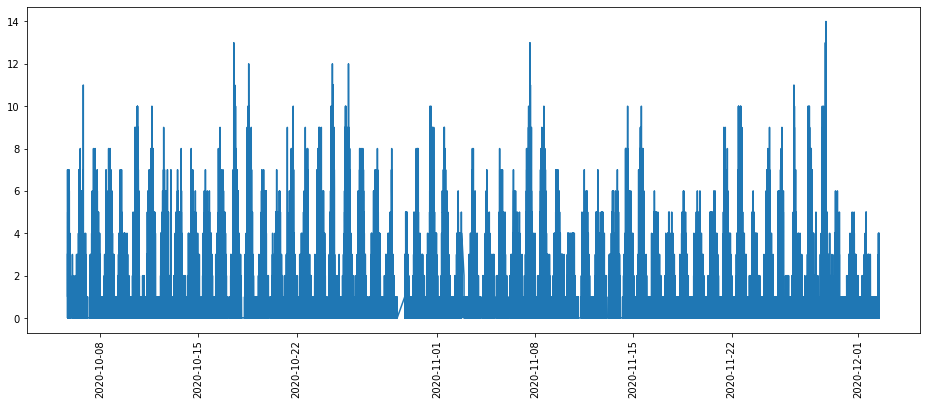

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
traffic_data = traffic_data.sort_values('timestamp', ascending=True)
plt.plot(traffic_data['timestamp'], traffic_data['human_count'])
plt.xticks(rotation='vertical')

In [86]:
# add datetime related features
traffic_data['date'] = traffic_data['timestamp'].dt.date
traffic_data['day_of_week'] = traffic_data['timestamp'].apply(lambda x: x.weekday())
traffic_data['hour'] = traffic_data['timestamp'].apply(lambda x: x.hour)
traffic_data

,human_count,timestamp,date,day_of_week,hour
0,3,2020-10-05 16:16:17,2020-10-05,0,16
1,2,2020-10-05 16:16:47,2020-10-05,0,16
2,5,2020-10-05 16:17:16,2020-10-05,0,16
3,2,2020-10-05 16:17:46,2020-10-05,0,16
4,1,2020-10-05 16:18:15,2020-10-05,0,16
...,...,...,...,...,...
116,1,2020-12-02 12:07:44,2020-12-02,2,12
117,0,2020-12-02 12:08:14,2020-12-02,2,12
118,1,2020-12-02 12:08:44,2020-12-02,2,12
119,2,2020-12-02 12:09:14,2020-12-02,2,12


In [87]:
# add feature for if the sun is up
import pytz
import datetime
from astral.sun import sun
from astral import LocationInfo
def sun_is_up(date, hour):
    city = LocationInfo('Atlanta', 'Georgia', 'America/New_York', 33.7490, -84.3880)
    s = sun(city.observer, date=date, tzinfo=city.timezone)
    return s['sunrise'] < datetime.datetime(date.year, date.month, date.day, hour, 0, 0, tzinfo=pytz.timezone(city.timezone)) < s['sunset']
traffic_data['sun_is_up'] = traffic_data.apply(lambda x: int(sun_is_up(x.date, x.hour)), axis=1)

In [88]:
# add feature for precipitation
weather_data = pd.read_csv('data/weather.csv')
weather_data = weather_data.query('STATION == "US1GAFT0057"')
weather_data['PRCP'] = weather_data.apply(lambda x: x.PRCP if x.PRCP is not None else x.MDPR, axis=1)
weather_data['DATE'] = pd.to_datetime(weather_data['DATE']).dt.date
weather_data['rained_on_day'] = weather_data['PRCP'].apply(lambda x: 1 if x > 0 else 0)
weather_data = weather_data[['DATE', 'PRCP', 'rained_on_day']]
weather_data.columns = ['date', 'precipitation_on_day', 'rained_on_day']
traffic_data = pd.merge(traffic_data, weather_data, how='left', on=['date'])

Counts of each value:


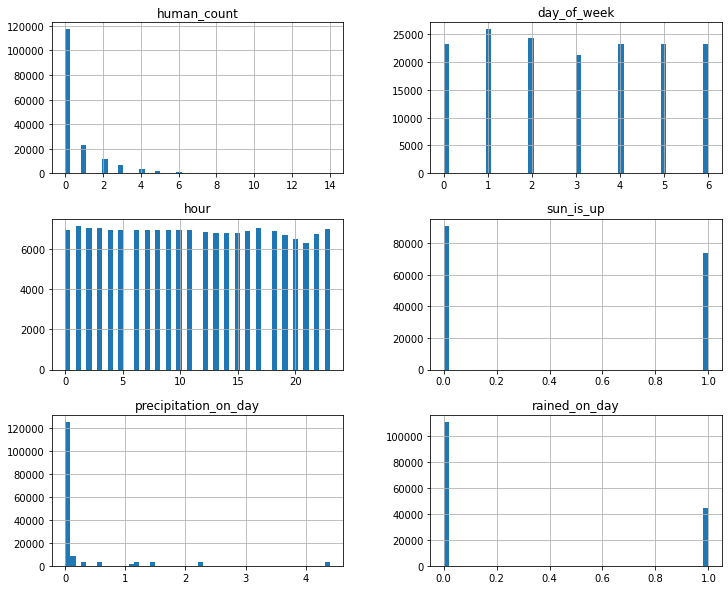

In [89]:
traffic_data.hist(bins=50, figsize=(12,10))
print('Counts of each value:')
plt.show()

In [90]:
# aggregate by hour
traffic_data = traffic_data.groupby(['date', 'hour', 'day_of_week', 'sun_is_up', 'precipitation_on_day', 'rained_on_day'])[['human_count']].agg('sum')
traffic_data = traffic_data.reset_index()
traffic_data

,date,hour,day_of_week,sun_is_up,precipitation_on_day,rained_on_day,human_count
0,2020-10-05,16,0,1,0.0,0.0,194
1,2020-10-05,17,0,1,0.0,0.0,122
2,2020-10-05,18,0,1,0.0,0.0,20
3,2020-10-05,19,0,0,0.0,0.0,136
4,2020-10-05,20,0,0,0.0,0.0,75
...,...,...,...,...,...,...,...
1267,2020-12-02,8,2,1,0.0,0.0,1
1268,2020-12-02,9,2,1,0.0,0.0,8
1269,2020-12-02,10,2,1,0.0,0.0,69
1270,2020-12-02,11,2,1,0.0,0.0,92


human_count over all hours:


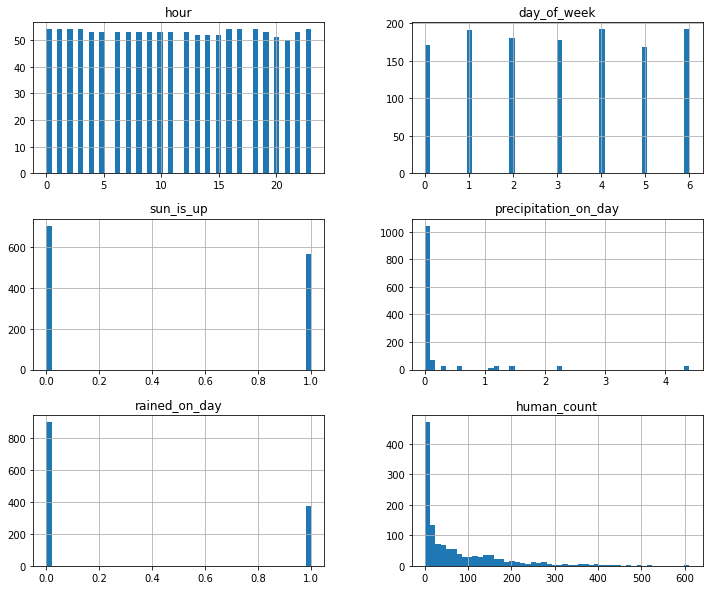

In [91]:
traffic_data.hist(bins=50, figsize=(12,10))
print('human_count over all hours:')
plt.show()

In [92]:
# make training and test set
import numpy as np
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(traffic_data, 0.2)
print(f'Training count: {str(len(train_set))}')
print(f'Test count: {str(len(test_set))}')
traffic_data = train_set

Training count: 1018
Test count: 254


In [93]:
traffic_data = traffic_data.drop('date', axis=1)

In [94]:
corr_matrix = traffic_data.corr()
corr_matrix['human_count'].sort_values(ascending=False)

human_count             1.000000
sun_is_up               0.583122
hour                    0.219472
day_of_week             0.192786
precipitation_on_day    0.038206
rained_on_day           0.024567
Name: human_count, dtype: float64

array([[<AxesSubplot:xlabel='hour', ylabel='hour'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='hour'>,
        <AxesSubplot:xlabel='sun_is_up', ylabel='hour'>,
        <AxesSubplot:xlabel='precipitation_on_day', ylabel='hour'>,
        <AxesSubplot:xlabel='rained_on_day', ylabel='hour'>,
        <AxesSubplot:xlabel='human_count', ylabel='hour'>],
       [<AxesSubplot:xlabel='hour', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='sun_is_up', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='precipitation_on_day', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='rained_on_day', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='human_count', ylabel='day_of_week'>],
       [<AxesSubplot:xlabel='hour', ylabel='sun_is_up'>,
        <AxesSubplot:xlabel='day_of_week', ylabel='sun_is_up'>,
        <AxesSubplot:xlabel='sun_is_up', ylabel='sun_is_up'>,
        <AxesSubplot:xlabel='precipitation_on_day', ylabel='s

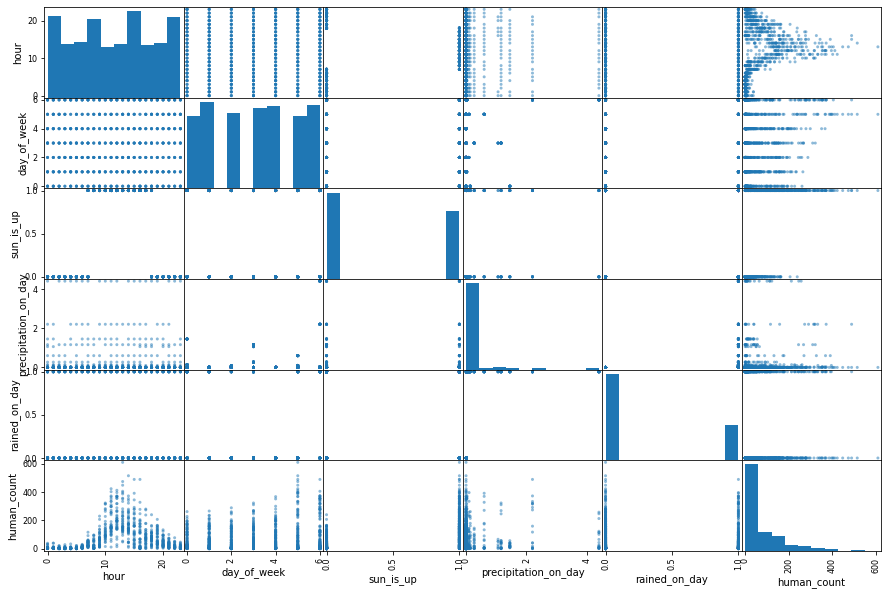

In [95]:
pd.plotting.scatter_matrix(traffic_data, figsize=(15,10))

In [96]:
# hour and day of week look the most promising

<AxesSubplot:xlabel='hour', ylabel='human_count'>

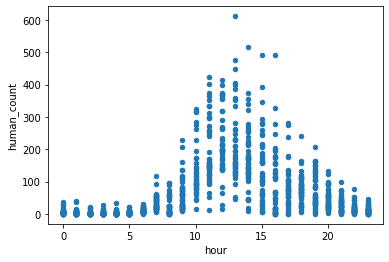

In [97]:
traffic_data.plot(kind='scatter', x='hour', y='human_count')

<AxesSubplot:xlabel='day_of_week', ylabel='human_count'>

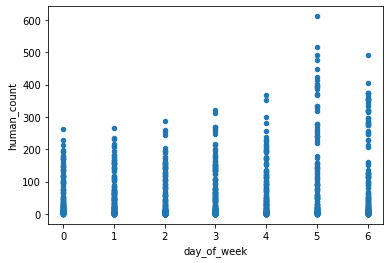

In [98]:
traffic_data.plot(kind='scatter', x='day_of_week', y='human_count')

In [99]:
human_count = pd.DataFrame(traffic_data['human_count'])
traffic_data = traffic_data.drop('human_count', axis=1)

In [100]:
# one hot encoding the day of week
traffic_data = pd.get_dummies(traffic_data, prefix=['day_of_week'], columns=['day_of_week'])

In [101]:
# making the hour feature cyclical
# http://blog.davidkaleko.com/feature-engineering-cyclical-features.html#The-Magic
traffic_data['hr_sin'] = np.sin(traffic_data.hour*(2.*np.pi/24))
traffic_data['hr_cos'] = np.cos(traffic_data.hour*(2.*np.pi/24))
traffic_data = traffic_data.drop('hour', axis=1)

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

for model in models:
    model.fit(traffic_data, human_count.values.ravel())
    some_data = traffic_data.iloc[:5]
    some_labels = human_count.iloc[:5]
    predictions = model.predict(some_data)
    
    print("\n\n" + str(type(model).__name__) + ': ')
    print("Predictions:\t" + str(predictions))
    print("Labels:\t\t" + str(list(some_labels['human_count'])))
    
    scores = cross_val_score(model, traffic_data, human_count.values.ravel(), scoring="neg_mean_squared_error", cv=10) 
    rmse_scores = np.sqrt(-scores)
    print("Scores: " + str(rmse_scores))
    print("Mean: " + str(rmse_scores.mean()))
    print("Standard deviation: " + str(rmse_scores.std()))

,human_count
243,72
32,2
156,5
923,1
578,119
...,...
1044,1
1095,2
1130,5
860,207
